In [1]:
import pathlib
import time
#import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split

import cv2
#image = cv2.imread("path")
#rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

from IPython import display

template = "numpy: v{np},  opencv: v{cv},  tensorflow: v{tf}"
print(template.format(np=np.__version__,
                      cv=cv2.__version__,
                      tf=tf.__version__))

numpy: v1.17.2,  opencv: v3.4.2,  tensorflow: v2.1.0-rc1


In [2]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
HIDDEN_DIM = 100
NUM_EXAMPLES = 16
SEED = tf.random.normal([NUM_EXAMPLES, HIDDEN_DIM])

EPOCHS = 50
CHECKPOINTS_PREFIX = "checkpoint"
CHECKPOINTS_DIR = "./checkpoints"

In [3]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    template = "image_at_epoch_{:04d}.png"
    plt.savefig(template.format(epoch))
    plt.show()

In [4]:
def create_generator():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

def create_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))

    return model

In [5]:
crossentropy = BinaryCrossentropy(from_logits=True)

def calculate_generator_loss(fake_output):
    return crossentropy(tf.ones_like(fake_output), fake_output)

def calculate_discriminator_loss(real_output, fake_output):
    real_loss = crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [6]:
generator = create_generator()
generator_optimizer = Adam(1e-4)

discriminator = create_discriminator()
discriminator_optimizer = Adam(1e-4)

tf.Tensor([[-0.00134516]], shape=(1, 1), dtype=float32)


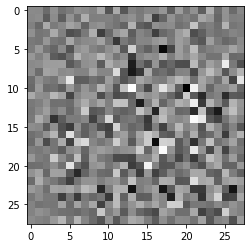

In [7]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
decision = discriminator(generated_image)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
print(decision)

In [8]:
@tf.function
def train_step(images_batch):
    hidden = tf.random.normal([BATCH_SIZE, HIDDEN_DIM])
    
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_images_batch = generator(hidden, training=True)
        real_output = discriminator(images_batch, training=True)
        fake_output = discriminator(generated_images_batch, training=True)
        
        generator_loss = calculate_generator_loss(fake_output)
        discriminator_loss = calculate_discriminator_loss(real_output, fake_output)
        
    generator_gradients = generator_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    

def train(dataset, epochs=EPOCHS, seed=SEED):
    for epoch in range(epochs):
        start = time.time()        
        for images_batch in dataset:
            train_step(images_batch)
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=CHECKPOINT_PREFIX)
        template = "Time for epoch {} is {} sec"
        print(template.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [9]:
mnist = tf.keras.datasets.mnist
(train_images, _), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

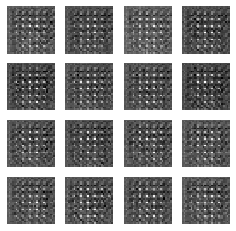

In [ ]:
train(train_dataset, EPOCHS)